### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter 
from scipy import stats
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import LabelEncoder
import time
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Function Definitions

In [2]:
# Convert data to numeric
def convert_dt_numeric(dataframe):
    datetime_float = []
    dct = {}
    indexes = list(dataframe.index.values.tolist())
    text_features_count = []

    for index in indexes:
        # counting total # of features
        if 'features' in dataframe:
            values = list(dataframe['features'][index])
            text_features_count.append(len(values))

        # converting time to float
        if 'created' in dataframe:
            datetime_obj = datetime.strptime(dataframe['created'][index], '%Y-%m-%d %H:%M:%S') 
            datetime_sec = time.mktime(datetime_obj.timetuple())
            datetime_float.append(datetime_sec)
    #     Convert float to datetime obj
    #     datetime_obj_after = datetime.fromtimestamp(datetime_sec) 
    #     print(datetime_obj, "=>", datetime_sec, "=>", datetime_obj_after)
    #     print(type(datetime_sec)) // float
    # dct
    if 'features' in dataframe:
        dataframe['text_features_count'] = text_features_count
    if 'created' in dataframe:
        dataframe['datetime_float'] = datetime_float

    # label interest_level => row : 2, medium : 1, high : 0
    if 'interest_level' in dataframe:
        lb_make = LabelEncoder()
        dataframe["interest_level_code"] = lb_make.fit_transform(dataframe["interest_level"])

    # Count total # of photos for each listing
    if 'photos' in dataframe:
        dataframe['num_photos'] = dataframe['photos'].apply(len)
    if 'bathrooms' and 'bedrooms' in dataframe:
        dataframe['total_rooms'] = dataframe['bathrooms'] + dataframe['bedrooms']
    return dataframe

# Remove Outliers, missing data and Drop Empty Fields
def clean_data(df2):
    newdf2 = df2[(df2['description'] != '') & (df2['description'] != '<p><a  website_redacted')]
    newdf2 = newdf2[newdf2['display_address'] != '']
    newdf2 = newdf2[newdf2['features'].str.len() > 0]
    newdf2 = newdf2[(newdf2['interest_level'] == 'low') | (newdf2['interest_level'] == 'medium') | (newdf2['interest_level'] == 'high')]
    newdf2 = newdf2[(newdf2['price'] != 10) & (newdf2['price'] != 0)]
    newdf2 = newdf2[newdf2['latitude'] != 0]
    newdf2 = newdf2[newdf2['longitude'] != 0]
    # newdf2 = newdf2[newdf2['photos'].str.len() > 0]
    newdf2 = newdf2[newdf2['street_address'].str.len() > 0]
    
    newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bathrooms'])) < 3)]
    newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bedrooms'])) < 3)]
    newdf2 = newdf2[(np.abs(stats.zscore(newdf2['latitude'])) < 3)]
    newdf2 = newdf2[(np.abs(stats.zscore(newdf2['longitude'])) < 3)]
    newdf2 = newdf2[(np.abs(stats.zscore(newdf2['price'])) < 3)]
    return newdf2

# Createa new column of the total count of text features for each row
def create_text_feature_count(newdf2):
    dct = {}
    indexes = list(newdf2.index.values.tolist())
    text_features_count = []
    for index in indexes:
        values = list(newdf2['features'][index])
        text_features_count.append(len(values))
    # dct
    
    newdf2['text_features_count'] = text_features_count
    return newdf2


# create interest level codes
# label interest_level = row : 2
# label interest_level = medium : 1
# label interest_level = high : 0
def create_interest_level_codes(newdf2):
    lb_make = LabelEncoder()
    newdf2["interest_level_code"] = lb_make.fit_transform(newdf2["interest_level"])
    return newdf2

def create_datetime_float(newdf2):
    indexes = list(newdf2.index.values.tolist())
    datetime_float = []
    for index in indexes:
        datetime_obj = datetime.strptime(newdf2['created'][index], '%Y-%m-%d %H:%M:%S') 
        datetime_sec = time.mktime(datetime_obj.timetuple())
        datetime_float.append(datetime_sec)
    #     Convert float to datetime obj
    #     datetime_obj_after = datetime.fromtimestamp(datetime_sec) 
    #     print(datetime_obj, "=>", datetime_sec, "=>", datetime_obj_after)
    #     print(type(datetime_sec)) // float
    newdf2['datetime_float'] = datetime_float
    return newdf2

def misc_formatting(newdf2, type):
    lrdf = newdf2
    lrdf['num_photos'] = lrdf['photos'].apply(len)
    lrdf['created'] = pd.to_datetime(lrdf['created'])
    #lrdf['hour'] = lrdf['created'].dt.hour
    #lrdf.dtypes
    
    #lrdf = lrdf.drop(columns=['interest_level', 'building_id', 'created', 'description', 'display_address', 'features', 'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'street_address'])
    if type == 'train':
        lrdf = lrdf.drop(columns=['interest_level', 'building_id', 'description', 'created', 'display_address', 'features', 'listing_id', 'manager_id', 'photos', 'street_address'])
    elif type == 'test':
        lrdf = lrdf.drop(columns=['building_id', 'description', 'created', 'display_address', 'features', 'listing_id', 'manager_id', 'photos', 'street_address'])
    return lrdf

def kaggle_export(labels, name, original_data, predicted):
    df_with_ps = original_data.copy(deep=True)
    df_with_ps['p_0_interest'] = [probs[0] for probs in labels]
    df_with_ps['p_1_interest'] = [probs[1] for probs in labels]
    df_with_ps['p_2_interest'] = [probs[2] for probs in labels]
    df_with_ps['predicted'] = predicted
    
    df_with_ps.rename(columns={'p_0_interest': 'high', 'p_1_interest': 'medium', 'p_2_interest': 'low'}, inplace=True)
    df2csv = df_with_ps[['listing_id', 'high', 'medium','low']]
    df2csv.to_csv(name, encoding='utf-8', index=False)

def hyper_param_grid(type):
    if type == 'random':
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 700, stop = 1500, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto'] # ['log2', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 80, num = 10)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10, 40, 50]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4, 8]
        # Method of selecting samples for training each tree
        bootstrap = [True]# Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
    elif type == 'grid':
        random_grid = {
            'bootstrap': [True],
            'oob_score': [False],
            'max_depth': [65, 70],
            'max_features': [3, 4],
            'min_samples_leaf': [2, 3],
            'min_samples_split': [35, 40, 45],
            'n_estimators': [250]}
            #'n_estimators': [900, 1200, 1000]}
    return random_grid
 
def train_data_wrapper(data):
    data = clean_data(data)
    data = create_text_feature_count(data)
    data = create_interest_level_codes(data)
    data = create_datetime_float(data)
    data = misc_formatting(data, 'train')
    return data

def test_data_wrapper(data):
    #data = clean_data(data)
    data = create_text_feature_count(data)
    #data = create_interest_level_codes(data)
    data = create_datetime_float(data)
    data = misc_formatting(data, 'test')
    return data


### Import, clean, and format data

In [3]:
# Import data, clean, and format for model
print('Cleaning & Formatting Data...')

tr_data = pd.read_json("./data/train.json")
te_data = pd.read_json("./data/test.json")

df = train_data_wrapper(tr_data)
test_df =  test_data_wrapper(te_data)
print('Finished...')

Cleaning & Formatting Data...
Finished...


## Random Forest Analysis - Model 1

In [4]:
# Random Forest Analysis
# ----------------------------------------------------------------------------------------------

cols = ['bathrooms', 'bedrooms', 'price', 'latitude', 'longitude', 'text_features_count', 'num_photos', 'datetime_float']

# Train Data
# ----------------------------------------------------------------------------------------------
print('Creating Model & Training Test Data...')

X = df[cols]
test_X = test_df[cols]
y = df['interest_level_code']

model1 = RandomForestClassifier()

kf = KFold(n_splits=5, shuffle=False)
scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index[0]:train_index[-1]], X[test_index[0]:test_index[-1]]
    y_train, y_test = y[train_index[0]:train_index[-1]], y[test_index[0]:test_index[-1]]
    model1.fit(X_train, np.ravel(y_train))
    scores.append(model1.score(X_test, y_test))


fi = pd.DataFrame({'feature': list(X.columns), 'importance': model1.feature_importances_}).sort_values('importance', ascending=False)

# Test
print('Testing Train and Test Data...')

predicted = model1.predict(test_X)
prob_labels = model1.predict_proba(test_X)

# Logloss
prob = model1.predict_proba(X)
predict_ll = log_loss(y, prob)

print("  Accuracy for first iteration:", round(np.mean(scores), 6), "+/-", round(np.std(scores)*2, 6))
print("  Log loss score:", predict_ll)
print("  Feature importances:", fi.head())

# Output predictions for Kaggle
print('Outputing predictions to csv...')
kaggle_export(prob_labels, 'model1.csv', te_data, predicted)
print('Finished...')


Creating Model & Training Test Data...


/home/kainoa/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Testing Train and Test Data...
('  Accuracy for first iteration:', 0.868741, '+/-', 0.275599)
('  Log loss score:', 0.5318574762886262)
('  Feature importances:',           feature  importance
2           price    0.205105
7  datetime_float    0.204975
3        latitude    0.170903
4       longitude    0.162935
6      num_photos    0.103810)
Outputing predictions to csv...
Finished...


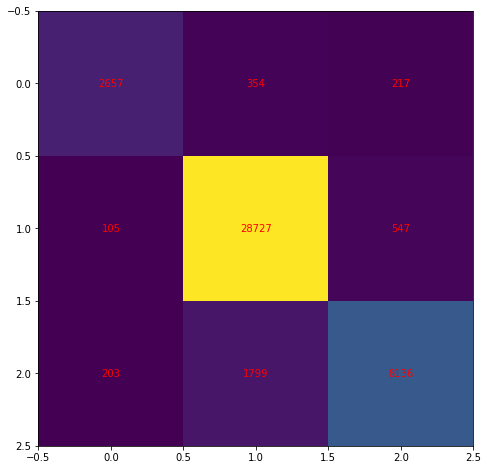

In [5]:
# Create Matrix

cm = confusion_matrix(y, model1.predict(X))
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(cm)
ax.grid(False)
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
#plt.show()
plt.savefig('matrix.png')

## Random Forest Analysis - Model 2  (Takes few minutes to complete)

In [6]:
# Random Forest Analysis
# ----------------------------------------------------------------------------------------------

df['num_rooms']=df['bathrooms']+df['bedrooms']
test_df['num_rooms']=test_df['bathrooms']+test_df['bedrooms']

cols = ['num_rooms', 'price', 'latitude', 'longitude', 'datetime_float']
print('original features:\n  ', tr_data.columns.values)
print('derived features:\n  ', df.columns.values)
print('selected features:\n  ', cols)


# Train Data
# ----------------------------------------------------------------------------------------------
print('Creating Model & Training Test Data...')

X = df[cols]
test_X = test_df[cols]
y = df['interest_level_code']

#model = DecisionTreeClassifier()
#model = RandomForestClassifier(n_estimators=400, bootstrap=True, max_features='sqrt')  # first model
#model = RandomForestClassifier(n_estimators=1500, bootstrap=True, max_features='auto', min_samples_split=5, min_samples_leaf=2, max_depth=80, 
#model = RandomForestClassifier(n_estimators=1200, bootstrap=True, max_features=4, min_samples_split=40, min_samples_leaf=4, max_depth=75, oob_score=True) 
model = RandomForestClassifier(n_estimators=1200, bootstrap=True, max_features='auto', min_samples_split=10, min_samples_leaf=4, max_depth=20, oob_score=True) 

#model = RandomizedSearchCV(estimator=forest, param_distributions=params, n_iter=60, cv=5, verbose=2, n_jobs=-1)
#model = GridSearchCV(estimator=forest, param_grid=params, verbose=2, n_jobs=-1)

print("init parameters:", model.get_params)
#kf = KFold(n_splits=5, shuffle=False)
#scores = []

"""
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index[0]:train_index[-1]], X[test_index[0]:test_index[-1]]
    y_train, y_test = y[train_index[0]:train_index[-1]], y[test_index[0]:test_index[-1]]
    model.fit(X_train, np.ravel(y_train))
    scores.append(model.score(X_test, y_test))
"""
model.fit(X, y)

fi = pd.DataFrame({'feature': list(X.columns), 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

# Test
print('Testing Train and Test Data...')
'''
print('train df shape:', df.shape)
print('test df shape:', test_df.shape)
print(X.shape)
print(y.shape)
'''

#print("best parameters:", model.best_params_)
predicted = model.predict(test_X)
prob_labels = model.predict_proba(test_X)

# Logloss
prob = model.predict_proba(X)
predict_ll = log_loss(y, prob)

#print("  Accuracy for first iteration:", round(np.mean(scores), 6), "+/-", round(np.std(scores)*2, 6))
print("  Accuracy for first iteration:", model.score(X, y))
print("  Log loss score:", predict_ll)
print("  Feature importances:", fi.head())


# Output predictions for Kaggle
print('Outputing predictions to csv...')
kaggle_export(prob_labels, 'model2.csv', te_data, predicted)
print('Finished...')


('original features:\n  ', array([u'bathrooms', u'bedrooms', u'building_id', u'created',
       u'description', u'display_address', u'features', u'interest_level',
       u'latitude', u'listing_id', u'longitude', u'manager_id', u'photos',
       u'price', u'street_address'], dtype=object))
('derived features:\n  ', array([u'bathrooms', u'bedrooms', u'latitude', u'longitude', u'price',
       'text_features_count', 'interest_level_code', 'datetime_float',
       'num_photos', 'num_rooms'], dtype=object))
('selected features:\n  ', ['num_rooms', 'price', 'latitude', 'longitude', 'datetime_float'])
Creating Model & Training Test Data...
('init parameters:', <bound method RandomForestClassifier.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_f

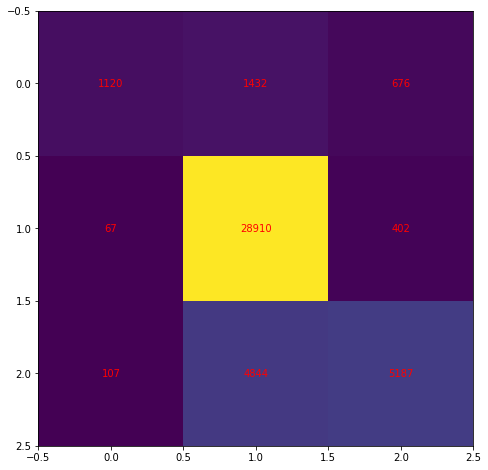

In [7]:
# Create Matrix

cm = confusion_matrix(y, model.predict(X))
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(cm)
ax.grid(False)
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
#plt.show()
plt.savefig('matrix.png')